# Medicare Fraud Detection
## Summary

Medicare provides health insurance for Americans aged 65 and older, younger people with some disabilities, as well as people with end stage disease. The authority has a list of excluded individuals and entities from healthcare program for reasons including conviction or fraud. 

The project is based on medicare part D prescription drug program data in 2013, which contains npi(physician,pharmacy id), prescription and patients information. I labeled the Npi appeared in the exclusion list in 2014 as the positive class. Then build classification models to detect the fraud.

The data is imbalanced with a fraud percentage of `0.25%` with ~1M records. In order to solve this issue, one way is to use LightGBM `scale_pos_weight` to apply weights on positive data and this model gives the accuracy at `0.72`. The second method is to downsample the negative class to make the two classes size equal. I built a logistic regression model and the accuracy boosted to`0.75`. Another popular way is to oversample the positive class. However, there are discussions that it is not a good approach for extremely imbalanced data. By doing some research I found a Talking Data Fraud Detection project on Kaggle which also has a similar imbalanced data with `0.24%` positive class. The winning solution is using downsampling.

For further model improvement, I will use `SMOTE` to oversample and apply `SGDClassifier` model which is proven efficient on large datasets.

## Coding

### Data preprocessing

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline


data = pd.read_csv('medicare-provider-utilization-and-payment-data-part-d-prescriber-summary-table-cy2013-1.csv')
data_deactivate = pd.read_csv('nppes-deactivated-npi-report_1.csv')
data['is_fraud'] = data['npi'].isin(data_deactivate['NPI']) *1

#data imbalance
data['is_fraud'].value_counts(normalize = True) # similar to Kaggle Talking data fraud detection .0024

0    0.997427
1    0.002573
Name: is_fraud, dtype: float64

### Feature Engineering

Text(0.5,1,'null values ratio')

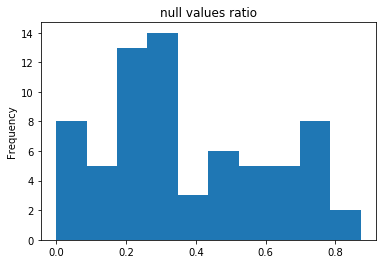

In [2]:
import matplotlib.pyplot as plt

# Preliminary feature selection, eliminate address, names, organization, provider's gender
column_filter = pd.read_csv('medi_column_filter.csv',header = 0)
data = data[column_filter['header'].values]

# check null values percentage
null_ratio = data.isnull().sum()/data.shape[0]
null_ratio.plot('hist')
plt.title('null values ratio')


We can see 0.4 is a good cutoff as most of features are below it. The feature with more than 40% null values will be removed.

### Filling na and transform categorical into integer

In [ ]:
#We can see 0.4 is a good cutoff as most of features are below it
data = data[null_ratio[null_ratio<=0.4].index.values]
#Fill numerical colums will 0, non-numerical with 'NA'
float_cols = data.select_dtypes(exclude=['object']).columns
str_cols = data.select_dtypes(include=['object']).columns
data.loc[:, float_cols] = data.loc[:, float_cols].fillna(data.loc[:, float_cols].mean())
data.loc[:, str_cols] = data.loc[:, str_cols].fillna('NA')
#Encoding categorical columns
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
for i in str_cols:
    data[i] = le.fit_transform(data[i])

### Modeling using LightGBM

The data is imbalanced. One way to deal with it is using LightGBM `scale_pos_weight` to apply weight on positive labels. When choosing the metric, ROC and F1 score are more invariant to imbalanced data because TPR and FPR are calculated for each class separately. AUC is chosen in this project.

In [9]:
import lightgbm as lgb
import time

def lgb_modelfit_nocv(params, dtrain, dvalid, predictors, target='target', objective='binary', metrics='auc',
                 feval=None, early_stopping_rounds=20, num_boost_round=3000, verbose_eval=10, categorical_features=None):
    lgb_params = {
        'boosting_type': 'gbdt',
        'objective': objective,
        'metric':metrics,
        'learning_rate': 0.01,
        'num_leaves': 15,  # we should let it be smaller than 2^(max_depth)
        'max_depth': 5,  # -1 means no limit
        'min_child_samples': 20,  # Minimum number of data need in a child(min_data_in_leaf)
        'max_bin': 255,  # Number of bucketed bin for feature values
        'subsample': 0.6,  # Subsample ratio of the training instance.
        'subsample_freq': 0,  # frequence of subsample, <=0 means no enable
        'colsample_bytree': 0.3,  # Subsample ratio of columns when constructing each tree.
        'min_child_weight': 5,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
        'subsample_for_bin': 200,  # Number of samples for constructing bin
        'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
        'reg_alpha': 0,  # L1 regularization term on weights
        'reg_lambda': 0,  # L2 regularization term on weights
        'nthread': 4,
        'verbose': 0,
        'metric':metrics,
    }

    lgb_params.update(params)

    print("preparing validation datasets")

    xgtrain = lgb.Dataset(dtrain[predictors].values, label=dtrain[target].values,
                          feature_name=predictors,
                          categorical_feature=categorical_features
                          )
    xgvalid = lgb.Dataset(dvalid[predictors].values, label=dvalid[target].values,
                          feature_name=predictors,
                          categorical_feature=categorical_features
                          )

    evals_results = {}

    bst1 = lgb.train(lgb_params, 
                     xgtrain, 
                     valid_sets=[xgtrain, xgvalid], 
                     valid_names=['train','valid'], 
                     evals_result=evals_results, 
                     num_boost_round=num_boost_round,
                     early_stopping_rounds=early_stopping_rounds,
                     verbose_eval=10, 
                     feval=feval)

    return bst1

In [10]:
# train, validation, test data split
len_train = int(len(data)*0.8)
test_df = data[len_train:]
val_df = data[(len_train-int(len_train*0.8)):len_train]
train_df = data[:(len_train-int(len_train*0.8))]

In [11]:
# remove predictor Npi, speficy categorical columns (lgb can deal with categorical directly)
target = 'is_fraud'
predictors = list(train_df.columns.values[1:])
categorical = list(str_cols)

In [12]:
params = {
    'learning_rate': 0.08,
    #'is_unbalance': 'true', # replaced with scale_pos_weight argument
    'num_leaves': 7,  # 2^max_depth - 1
    'max_depth': 3,  # -1 means no limit
    'min_child_samples': 100,  # Minimum number of data need in a child(min_data_in_leaf)
    'max_bin': 100,  # Number of bucketed bin for feature values
    'subsample': 0.7,  # Subsample ratio of the training instance.
    'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
    'colsample_bytree': 0.9,  # Subsample ratio of columns when constructing each tree.
    'min_child_weight': 0,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
    'scale_pos_weight':50 # because training data is extremely unbalanced 
}

In [13]:
#train the model
print("Training...")
start_time = time.time()

bst = lgb_modelfit_nocv(params, 
                        train_df, 
                        val_df, 
                        predictors, 
                        target, 
                        objective='binary', 
                        metrics='auc',
                         early_stopping_rounds=30, 
                        verbose_eval=True, 
                        num_boost_round=500, 
                        categorical_features=categorical)

print('[{}]: model training time'.format(time.time() - start_time))

Training...
preparing validation datasets


C:\Users\xgao\Anaconda3\lib\site-packages\lightgbm\basic.py:1027: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\xgao\Anaconda3\lib\site-packages\lightgbm\basic.py:668: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')


Training until validation scores don't improve for 30 rounds.
[10]	train's auc: 0.732662	valid's auc: 0.692506
[20]	train's auc: 0.746387	valid's auc: 0.702089
[30]	train's auc: 0.77248	valid's auc: 0.711988
[40]	train's auc: 0.790867	valid's auc: 0.714371
[50]	train's auc: 0.808252	valid's auc: 0.717673
[60]	train's auc: 0.823907	valid's auc: 0.720401
[70]	train's auc: 0.837432	valid's auc: 0.72159
[80]	train's auc: 0.844546	valid's auc: 0.722327
[90]	train's auc: 0.854993	valid's auc: 0.723491
[100]	train's auc: 0.865195	valid's auc: 0.722641
[110]	train's auc: 0.874081	valid's auc: 0.722994
[120]	train's auc: 0.880871	valid's auc: 0.722819
Early stopping, best iteration is:
[91]	train's auc: 0.855856	valid's auc: 0.723516
[15.234267234802246]: model training time


Result on test data

In [15]:
#test result
from sklearn import metrics
y = test_df['is_fraud']
pred = bst.predict(test_df[predictors])
fpr,tpr,thresholds = metrics.roc_curve(y,pred)
model1 = metrics.auc(fpr,tpr)
model1

0.7274070077732018

### Downsample
Another method is to downsample the negative class and make the two classes size equal. Then build a logistic regression.

In [16]:
class0_id = np.where(data['is_fraud']==0)[0]
class1_id = np.where(data['is_fraud']==1)[0]
n_class0 = len(class0_id)
n_class1 = len(class1_id)
np.random.seed(21619)
down_sample = np.random.choice(class0_id, size = n_class1, replace = False)
id_all = np.hstack((class1_id, down_sample))
data_balance = data[data.index.isin(id_all)]
#shuffle data
data = data_balance.sample(frac = 1)

In [18]:
# train, validation, test data split
len_train = int(len(data)*0.8)
test_df = data[len_train:]
train_df = data[:len_train]

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

logreg = LogisticRegression()
Xtrain = train_df[predictors]
ytrain = train_df['is_fraud']
logreg.fit(Xtrain, ytrain)

#test result
from sklearn import metrics
y = test_df['is_fraud']
pred = logreg.predict(test_df[predictors])
fpr,tpr,thresholds = metrics.roc_curve(y,pred)
model2 = metrics.auc(fpr,tpr)
model2

C:\Users\xgao\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\xgao\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.7555688930806825

### Oversample

I will use SMOTE algorithm which randomly chooses one of the k neareast neighbors and uses it to create a similar but tweaked observation.

In [42]:
from imblearn.over_sampling import SMOTE

len_train = int(len(data)*0.8)
test_df = data[len_train:]
train_df = data[:len_train]

Xtrain = train_df[predictors]
ytrain = train_df['is_fraud']

os = SMOTE(random_state = 21619)
os_X,os_y = os.fit_sample(Xtrain, ytrain)

Since we oversample, we have 2M records now. `SGDclassifier`is proven to be efficient in large scale datasets.

In [ ]:
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier(loss = 'hinge',penalty = 'l2',max_iter=10000,alpha = 1)
clf.fit(os_X,os_y)

### Reference and data source

[Detecting Medicare Fraud](https://blog.dataiku.com/2015/08/12/medicare-fraud)

[Npi deactivation list 2014](https://data.world/cms/qbms-kuqs)

[Medicare provider utilization and payment data](https://data.world/cms/cks9-s5d9)

[Data description](https://data.cms.gov/Medicare-Part-D/Medicare-Provider-Utilization-and-Payment-Data-Par/cks9-s5d9)